# Simple Linear Regression

Linear Regression using MSE as cost function optimised by GradientDescentOptimiser.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

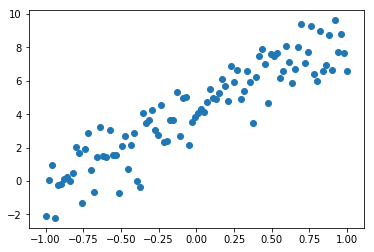

In [2]:
# simulate linear data
x_train = np.linspace(-1, 1, 100)
# y = 4.5 x + 10
y_train = 4.5 * x_train + np.random.randn(x_train.shape[0]) + np.random.randn() * 10

n_samples = x_train.shape[0]

plt.scatter(x_train, y_train)
plt.show()

In [21]:
# place holder for data
X = tf.placeholder(dtype=tf.float32)
Y = tf.placeholder(dtype=tf.float32)

# create variables for weights and bias
w = tf.Variable(np.random.randn(), name='weight')
b = tf.Variable(np.random.randn(), name='bias')

# create a linear model y = wx + b
y_model = tf.add(tf.multiply(X, w), b)

# MSE fn to calculate the error of fitted model
mse = tf.reduce_mean(tf.square(Y - y_model))

# create a cost function(s) to be optimised during training
# MSE reduced most by 2nd one

# cost = tf.reduce_mean(tf.square(Y - y_model))
cost = tf.reduce_sum(tf.square(Y - y_model))/(2 * n_samples)
# cost = tf.reduce_sum(tf.square(Y - y_model))

# create an optimiser to optimise cost fn
train_op = tf.train.GradientDescentOptimizer(learning_rate = 0.1).minimize(cost)

# train the linear model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # 100 epochs
    for i in range(100):
        for (x, y) in zip(x_train, y_train):
            sess.run(train_op, feed_dict = {X: x, Y: y})
        
        print('epoch {}: weight={}, bias={}, MSE={}'.format(i, sess.run(w), sess.run(b), sess.run(mse,\
                                                                feed_dict={X: x_train, Y: y_train})))
    
    print('Trained Model:')
    weight = sess.run(w)
    bias = sess.run(b)
    print('weight={}, bias={}, MSE={}'.format(weight, bias, sess.run(mse,\
                                                                feed_dict={X: x_train, Y: y_train})))
    
    # running the trained model to get predicted y values
    y_fitted = sess.run(y_model, feed_dict={X: x_train})

epoch 0: weight=0.7974063158035278, bias=1.2097326517105103, MSE=15.102492332458496
epoch 1: weight=0.9185311198234558, bias=1.5005193948745728, MSE=13.13647747039795
epoch 2: weight=1.0359716415405273, bias=1.7634559869766235, MSE=11.49405288696289
epoch 3: weight=1.1498156785964966, bias=2.0012013912200928, MSE=10.118416786193848
epoch 4: weight=1.260151743888855, bias=2.216158628463745, MSE=8.962997436523438
epoch 5: weight=1.367068886756897, bias=2.4105019569396973, MSE=7.989574432373047
epoch 6: weight=1.4706544876098633, bias=2.5861992835998535, MSE=7.166772365570068
epoch 7: weight=1.570997714996338, bias=2.7450320720672607, MSE=6.468813419342041
epoch 8: weight=1.6681855916976929, bias=2.8886098861694336, MSE=5.874522686004639
epoch 9: weight=1.7623040676116943, bias=3.0183889865875244, MSE=5.366486072540283
epoch 10: weight=1.8534389734268188, bias=3.1356890201568604, MSE=4.930366039276123
epoch 11: weight=1.9416742324829102, bias=3.24170184135437, MSE=4.554357051849365
epoch 

### Observations
Cost functions used:
1. cost = tf.reduce_mean(tf.square(Y - y_model))
2. cost = tf.reduce_sum(tf.square(Y - y_model))/(2 * n_samples)
3. cost = tf.reduce_sum(tf.square(Y - y_model))


* (2) gives the minimum MSE for trained model. At each epoch weights and bias are updated, giving a more fitting model in the end.
* (1 & 3) gives a larger MSE and also weights and bias stop updating after 4-5 epochs. Dont know why. Model also does not fit well.

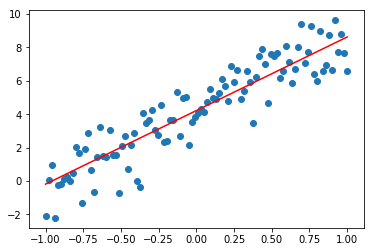

In [22]:
plt.scatter(x_train, y_train)
plt.plot(x_train, y_fitted, 'r')
plt.show()

# Polynomial Regression
Dataset: ship_speed_fuel.csv

Dataset is read using QueueRunner in multithreaded fashion. An input pipeline is built, which consists of a queue and a TextLineReader. On starting a QueueRunner, the queue is populated by data. The reader reads the data from queue and passes it to a csv_decoder() , which decodes the string row into columns and attribute values. 

During training, as sess is run on speed and fuel tensors, a data unit (row in this case) is dequeued and passed to csv_decoder(), which returns the values of columns. These values are used to train the model.

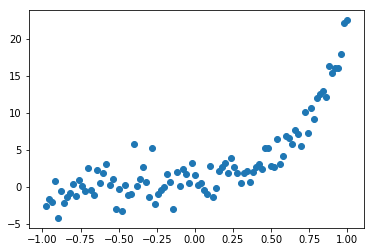

In [2]:
# plot data
# simulated polynomial data stored in a csv file
import pandas as pd
df = pd.read_csv('Datasets/ship_speed_fuel.csv')
x_train = np.asarray(df.iloc[:,0])
y_train = np.asarray(df.iloc[:,1])

plt.scatter(x_train, y_train)
plt.show()

In [3]:
# returns operations that will read single row of csv
def read_input_pipeline(epochs, filename):
    # take input using QueueRunner - csv file
    queue = tf.train.string_input_producer([filename], num_epochs = epochs, shuffle = False)

    # create a reader
    reader = tf.TextLineReader()
    key_op, value_op = reader.read(queue, name='csv_reader')

    # default values for empty columns
    default_values = [[0.0], [0.0]]
    col1, col2 = tf.decode_csv(value_op, record_defaults=default_values)
    
    return col1, col2

Build a model of degree n: 
y = w<sub>0</sub> + w<sub>1</sub>*x + w<sub>2</sub>*x<sup>2</sup> + ...... + w<sub>n</sub>x<sup>n</sup>

In [4]:
# build a polynomial model
def build_polynomial_model(X, degree):
    # initialize weights and bias with random values
    w = tf.Variable([np.random.randn()] * (degree + 1), name = 'weights')
    
    terms = []
    # add polynomial terms upto degree specified
    for i in range(degree + 1):
        term = tf.multiply(w[i], tf.pow(X, i))
        terms.append(term)
    
    model = tf.add_n(terms)
    
    return model, w

In [6]:
def train_model(filename, epochs, degree = 2, learning_rate = 0.1):
    X = tf.placeholder(dtype = tf.float32)
    Y = tf.placeholder(dtype = tf.float32)

    y_model, w = build_polynomial_model(X, degree)

    # create a cost function to optimise
    n_samples = x_train.shape[0]

    # MSE fn to evaluate error of trained model
    mse = tf.reduce_mean(tf.square(Y - y_model))
    
    # cost fn to minimise during training
#     cost = tf.reduce_sum(tf.square(Y - y_model))/(2 * n_samples)
    cost = tf.reduce_mean(tf.square(Y - y_model))

    global_step = tf.Variable(0, trainable = False)
    train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost, global_step = global_step)

    # setup input pipeline to get X and Y values
    x_op, y_op = read_input_pipeline(epochs, filename)

    # set up session and train polynomial model
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())

        # initialise global_step with 0
        sess.run(tf.assign(global_step, 0))
        epoch = 0
        
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord = coord)

        try:
            while not coord.should_stop():
                # data is being read from queues and printed
                # get data and use it to train model
                x, y = sess.run([x_op, y_op])
                sess.run(train_op, feed_dict={X: x, Y: y})
#                 if sess.run(global_step) % n_samples == 0:
#                     print('epoch={}, weight={}, MSE={}'.format(epoch, sess.run(w),\
#                                                     sess.run(mse, feed_dict={X: x_train, Y: y_train})))
#                     epoch += 1

        except tf.errors.OutOfRangeError:
            print('Trained Model is:')
            print('weight={}, MSE={}'.format(sess.run(w),\
                                                    sess.run(mse, feed_dict={X: x_train, Y: y_train})))
        finally:
            coord.request_stop()

        coord.join(threads)
        # get fitted values
        
        y_fitted = sess.run(y_model, feed_dict={X: x_train})
        
        return y_fitted

Train polynomial models with degrees 2,3,4,5 and plot the results.

Trained Model is:
weight=[-1.2762153  6.5315785 16.741642 ], MSE=13.253766059875488
Trained Model is:
weight=[ 0.47415134 -1.5785997   7.972124   15.635021  ], MSE=3.395057439804077
Trained Model is:
weight=[ 0.99798596 -0.51138806  2.4516933  12.882481    6.684536  ], MSE=2.7707602977752686
Trained Model is:
weight=[0.8905132 1.5496029 3.695491  5.080225  5.0823812 5.9365416], MSE=2.5880320072174072


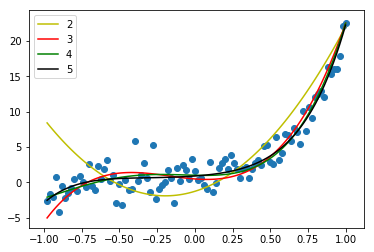

In [7]:
y_fitted = train_model('Datasets/ship_speed_fuel.csv', epochs = 50, degree = 2, learning_rate = 0.1)
plt.plot(x_train, y_fitted, 'y', label = '2')
y_fitted = train_model('Datasets/ship_speed_fuel.csv', epochs = 50, degree = 3, learning_rate = 0.1)
plt.plot(x_train, y_fitted, 'r', label = '3')
y_fitted = train_model('Datasets/ship_speed_fuel.csv', epochs = 50, degree = 4, learning_rate = 0.1)
plt.plot(x_train, y_fitted, 'g', label = '4')
y_fitted = train_model('Datasets/ship_speed_fuel.csv', epochs = 50, degree = 5, learning_rate = 0.1)
plt.plot(x_train, y_fitted, 'k', label = '5')

# plot fitted model
plt.scatter(x_train, y_train)
plt.legend()
plt.show()